In [1]:
import sys
src_dir = '/Users/palmerio/Science_projects/GRB_population_model/src/'
sys.path.insert(0, src_dir)
verbose = True
run_mode = 'debug'

# GRB pop module imports
from GRB_population import GRBPopulation
import physics as ph
import stats as st
import io_grb_pop as io
from io_grb_pop import root_dir
import miscellaneous as msc
import plotting_functions as pf
from cosmology import init_cosmology
from ECLAIRs import init_ECLAIRs
import observational_constraints as obs

# General imports
import yaml
import logging
import corner
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

# specific imports
from scipy.stats import ks_2samp
from scipy.stats import norm
from scipy.stats import mstats
from itertools import product

log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG,
                    format='%(asctime)s.%(msecs)03d [%(levelname)s] %(message)s',
                    datefmt='%H:%M:%S')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
plt.style.use('paper')
colors = ['#225ea8', '#41b6c4', '#d94801', '#fd8d3c']

In [50]:
mod = 'k0_LN_nF'
df = pd.read_parquet(f'../model_outputs_non-dockerized/best_populations/population_{mod}')

In [51]:
paths_to_dir, paths_to_files = io.generate_paths()
config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
obs.load_observational_constraints(obs_constraints)
# cosmo = init_cosmology(paths_to_dir['cosmo'])
# ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
#                             ECLAIRs_config=instruments['ECLAIRs'])
# samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']
# incl_samples, incl_instruments, incl_constraints = msc.create_config(config=config,
#                                                        samples=samples,
#                                                        instruments=instruments,
#                                                        obs_constraints=obs_constraints)

10:20:41.433 [DEBUG] Root directory is /Users/palmerio/Science_projects/GRB_population_model
10:20:41.434 [DEBUG] Directory paths :
    'root'    : /Users/palmerio/Science_projects/GRB_population_model
    'obs'     : /Users/palmerio/Science_projects/GRB_population_model/observational_constraints
    'init'    : /Users/palmerio/Science_projects/GRB_population_model/init
    'output'  : /Users/palmerio/Science_projects/GRB_population_model/model_outputs
    'data'    : /Users/palmerio/Science_projects/GRB_population_model/data
    'cosmo'   : /Users/palmerio/Science_projects/GRB_population_model/data/cosmology
    'ECLAIRs' : /Users/palmerio/Science_projects/GRB_population_model/data/ECLAIRs
10:20:41.435 [DEBUG] File paths :
    'config'          : /Users/palmerio/Science_projects/GRB_population_model/init/config.yml
    'param'           : /Users/palmerio/Science_projects/GRB_population_model/init/parameters.yml
    'instrum'         : /Users/palmerio/Science_projects/GRB_population_mo

{'Stern': {'instrument': 'BATSE',
  'val_min': 0.066825,
  'prop_min': 'pht_pflx_BATSE',
  'quantity': 'pht_pflx_BATSE',
  'sum_ln_oi_factorial': 36306.10949982049,
  'last_bin': 50.0,
  'bins': array([ 0.06682496,  0.08412765,  0.1059104 ,  0.1333333 ,  0.1678567 ,
          0.2113191 ,  0.266035  ,  0.3349182 ,  0.421637  ,  0.5308096 ,
          0.6682496 ,  0.8412765 ,  1.059104  ,  1.333333  ,  1.678567  ,
          2.113191  ,  2.66035   ,  3.349182  ,  4.21637   ,  5.308096  ,
          6.682496  ,  8.412765  , 10.59104   , 13.33333   , 16.        ,
         20.        , 28.        , 50.        ]),
  'hist': array([746.99836305, 709.32094461, 756.00473949, 617.55929317,
         621.94179567, 518.76365179, 425.72123059, 379.29601979,
         340.29977925, 301.4922593 , 291.04466987, 247.76090788,
         244.77638589, 201.49286007, 180.59708794, 131.34318358,
         126.86572593,  83.58210131,  73.13439404,  65.67153481,
          37.313471  ,  35.82084148,  31.34328547,  23

In [52]:
GRB_pop = GRBPopulation(properties=df)
GRB_pop.create_mock_constraint(obs_constraints=obs_constraints)
GRB_pop.compare_to_observational_constraints(obs_constraints=obs_constraints, method='chi2')

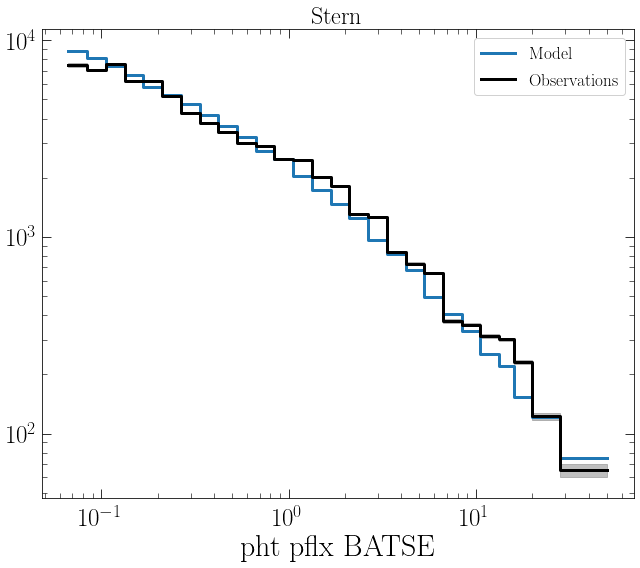

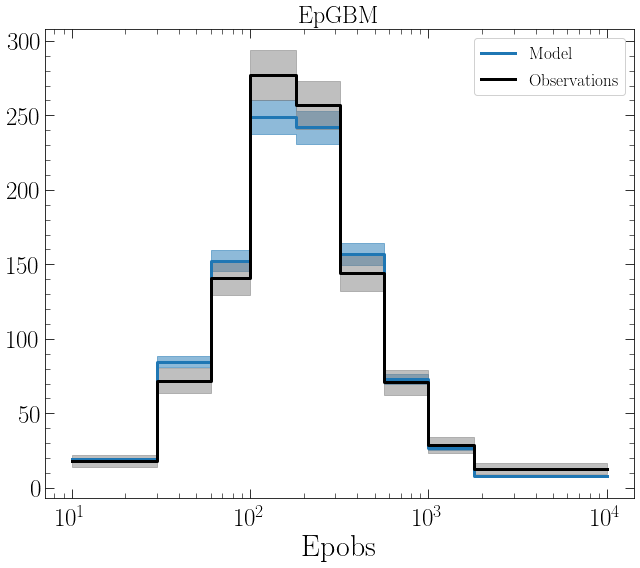

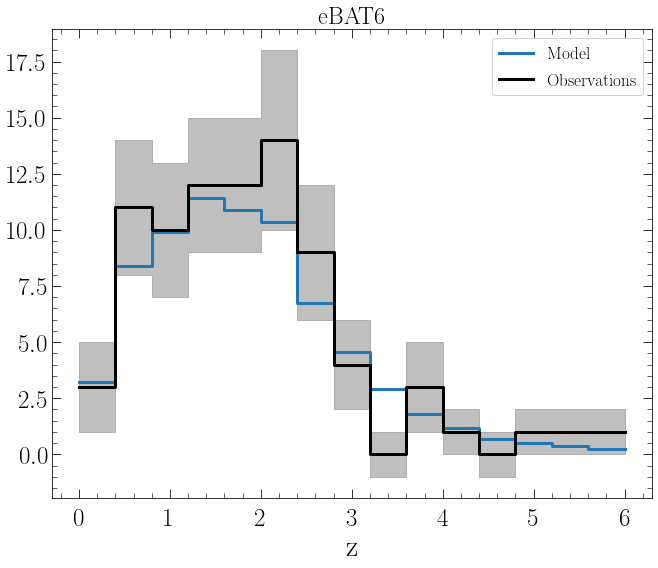

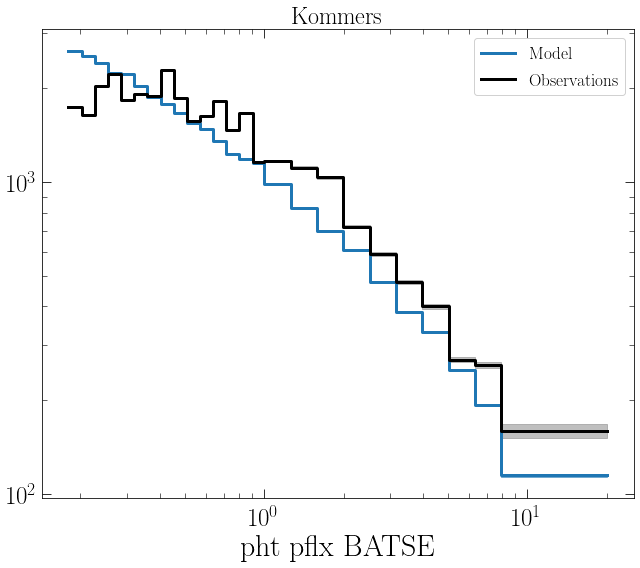

In [53]:
for name, constraint in GRB_pop.mock_constraints.items():
    
    bins = constraint['bins']
    constr_mod = constraint['hist']
    constr_err_mod = constraint['hist']*constraint['norm']
    constr_obs = obs_constraints[name]['hist']
    constr_err_obs = obs_constraints[name]['err']
    if name in ['Stern', 'Kommers']:
        constr_mod = constr_mod / np.log10(bins[1:]/bins[:-1])
        constr_obs = constr_obs / np.log10(bins[1:]/bins[:-1])
    bins_to_plot, hist_to_plot = pf.plottable_hist(x_in=bins[:-1],
                                                   y_in=constr_mod,
                                                   last_bin_edge=bins[-1])
    bins_to_plot, err_to_plot = pf.plottable_hist(x_in=bins[:-1],
                                                   y_in=constr_err_mod,
                                                   last_bin_edge=bins[-1])
    bins_to_plot, hist_obs = pf.plottable_hist(x_in=bins[:-1],
                                               y_in=constr_obs,
                                               last_bin_edge=bins[-1])
    bins_to_plot, err_obs = pf.plottable_hist(x_in=bins[:-1],
                                               y_in=constr_err_obs,
                                               last_bin_edge=bins[-1])
    fig, ax = plt.subplots(figsize=(9,8))
    ax.set_title(name)
    ax.plot(bins_to_plot, hist_to_plot, color='C0', label='Model')
    ax.fill_between(bins_to_plot, hist_to_plot+err_to_plot, hist_to_plot-err_to_plot, color='C0', alpha=0.5)
    ax.plot(bins_to_plot, hist_obs, color='k', label='Observations')
    ax.fill_between(bins_to_plot, hist_obs+err_obs, hist_obs-err_obs, color='gray', alpha=0.5)
    ax.set_xlabel(constraint['quantity'].replace('_',' '))
    ax.legend()
    if name != 'eBAT6':
        ax.set_xscale('log')
    if name in ['Stern', 'Kommers']:
        ax.set_yscale('log')
plt.show()

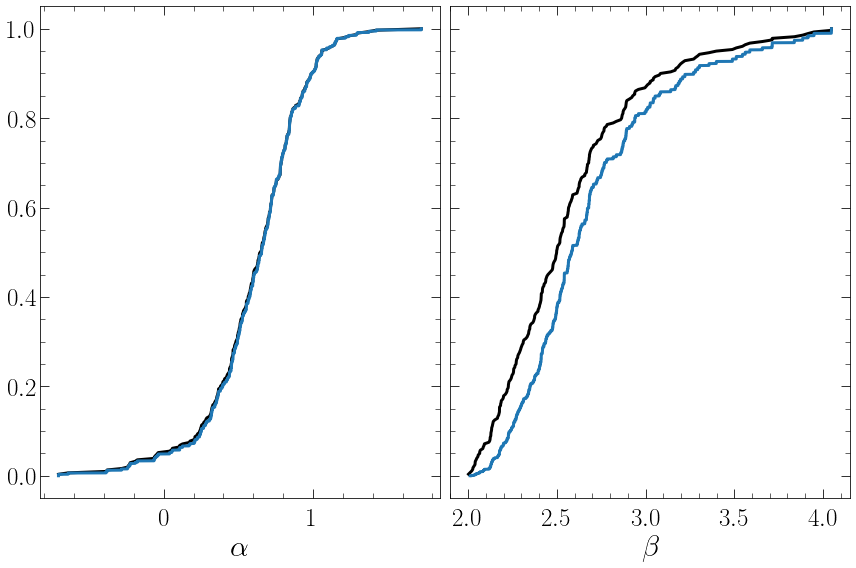

In [54]:
# Look at the alpha and beta distributions for GBM
alpha_obs = io.read_column('../data/good_alpha_GBM.txt', 0)
alpha_CDF_obs = io.read_column('../data/good_alpha_GBM.txt', 1)
beta_obs = io.read_column('../data/good_beta_GBM.txt', 0)
beta_CDF_obs = io.read_column('../data/good_beta_GBM.txt', 1)

GBM_cond = df['pdet_EpGBM'] == 1
alpha_mod, alpha_CDF_mod = st.unbinned_empirical_cdf(df[GBM_cond]['alpha'].to_numpy())
beta_mod, beta_CDF_mod = st.unbinned_empirical_cdf(df[GBM_cond]['beta'].to_numpy())

fig, axes = plt.subplots(1,2, figsize=(12,8), sharey=True)
axa = axes[0]
axb = axes[1]
axa.plot(alpha_obs, alpha_CDF_obs, color='k')
axa.plot(alpha_mod, alpha_CDF_mod, color='C0')
axb.plot(beta_obs, beta_CDF_obs, color='k')
axb.plot(beta_mod, beta_CDF_mod, color='C0')

axa.set_xlabel(r'$\alpha$')
axb.set_xlabel(r'$\beta$')

plt.show()

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


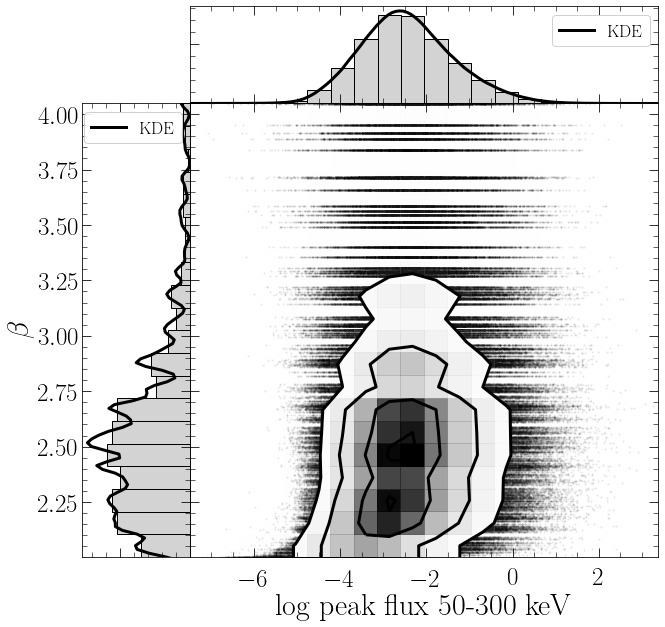

In [57]:
fig, axes = pf.cool_hist2d(np.log10(df['pht_pflx_BATSE']).to_numpy(),
                           df['beta'].to_numpy(),
                           cb=False,
                           mode='hist2d',
                           figsize=(10,9),
                           plot_left_kdeplot=True,
                           plot_top_kdeplot=True)
axes['center'].set_xlabel('log peak flux 50-300 keV')
axes['left'].set_ylabel(r'$\beta$')
plt.show()

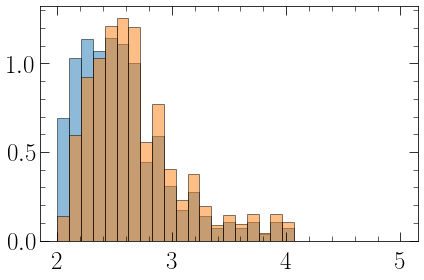

In [49]:
bins=np.linspace(2,5,30)
plt.hist(df['beta'], bins=bins, density=True, label='All', alpha=0.5)
plt.hist(df[GBM_cond]['beta'], bins=bins, density=True, label='Ep GBM', alpha=0.5)
plt.show()

In [61]:
obs_constraints['Stern']

{'instrument': 'BATSE',
 'val_min': 0.066825,
 'prop_min': 'pht_pflx_BATSE',
 'quantity': 'pht_pflx_BATSE',
 'sum_ln_oi_factorial': 36306.10949982049,
 'last_bin': 50.0,
 'bins': array([ 0.06682496,  0.08412765,  0.1059104 ,  0.1333333 ,  0.1678567 ,
         0.2113191 ,  0.266035  ,  0.3349182 ,  0.421637  ,  0.5308096 ,
         0.6682496 ,  0.8412765 ,  1.059104  ,  1.333333  ,  1.678567  ,
         2.113191  ,  2.66035   ,  3.349182  ,  4.21637   ,  5.308096  ,
         6.682496  ,  8.412765  , 10.59104   , 13.33333   , 16.        ,
        20.        , 28.        , 50.        ]),
 'hist': array([746.99836305, 709.32094461, 756.00473949, 617.55929317,
        621.94179567, 518.76365179, 425.72123059, 379.29601979,
        340.29977925, 301.4922593 , 291.04466987, 247.76090788,
        244.77638589, 201.49286007, 180.59708794, 131.34318358,
        126.86572593,  83.58210131,  73.13439404,  65.67153481,
         37.313471  ,  35.82084148,  31.34328547,  23.8806069 ,
         22.3880

In [63]:
np.sum(obs_constraints['Stern']['hist'])/6.54

1108.3702614097156

In [65]:
np.sqrt(np.sum(obs_constraints['Stern']['err']**2))/6.54

36.29216542605549

0